Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 632ms/step - accuracy: 0.3765 - loss: 1.5022 - val_accuracy: 0.4550 - val_loss: 1.0656
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 633ms/step - accuracy: 0.3511 - loss: 1.0989 - val_accuracy: 0.4550 - val_loss: 1.0940
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 649ms/step - accuracy: 0.4237 - loss: 1.0937 - val_accuracy: 0.4550 - val_loss: 1.0891
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 662ms/step - accuracy: 0.4184 - loss: 1.0894 - val_accuracy: 0.4550 - val_loss: 1.0853


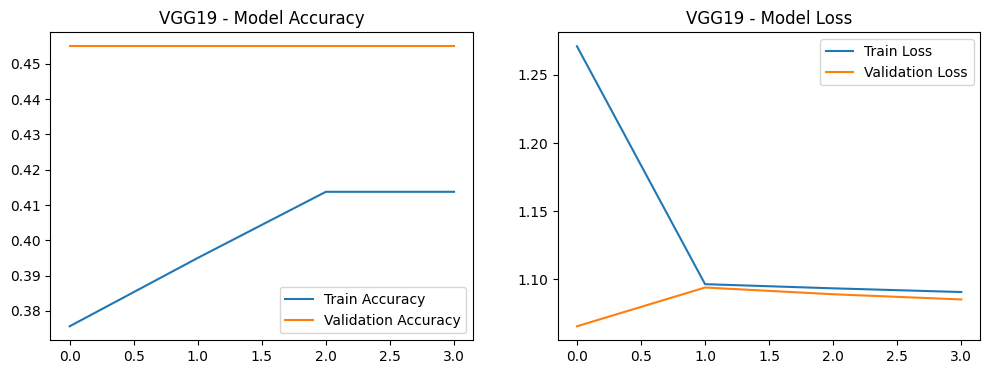

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 493ms/step


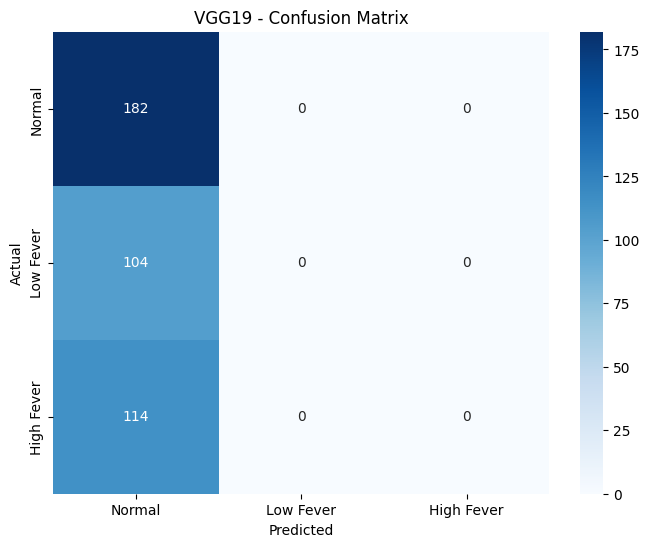

VGG19 - Classification Report
              precision    recall  f1-score   support

      Normal       0.46      1.00      0.63       182
   Low Fever       0.00      0.00      0.00       104
  High Fever       0.00      0.00      0.00       114

    accuracy                           0.46       400
   macro avg       0.15      0.33      0.21       400
weighted avg       0.21      0.46      0.28       400



C:\Users\eshwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eshwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\eshwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate synthetic data
def generate_data():
    temperatures = np.random.uniform(35, 41, size=2000)
    labels = []
    for temp in temperatures:
        if temp < 37.5:
            labels.append(0)  # Normal
        elif 37.5 <= temp < 39:
            labels.append(1)  # Low Fever
        else:
            labels.append(2)  # High Fever
    data = pd.DataFrame({"Temperature": temperatures, "Label": labels})
    return data

# Create synthetic data and save it
data = generate_data()
data.to_csv("temperature_data.csv", index=False)

# Load the data
data = pd.read_csv("temperature_data.csv")
X = data["Temperature"].values
y = data["Label"].values

# Preprocess data into image-like format
X = np.array([[[[temp] * 128] * 128 for temp in X]])
X = X.reshape(-1, 128, 128, 1)  # Reshape to (samples, height, width, channels)
X = np.repeat(X, 3, axis=-1)  # Convert to 3 channels

# Normalize the data
X = X / 41.0  # Normalize based on the max temperature value

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load VGG19 base model
vgg19_base = VGG19(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
vgg19_base.trainable = False

# Create the model
model = models.Sequential([
    vgg19_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Normal, Low Fever, High Fever
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Save the trained model
model.save('vgg19_temperature_model.h5')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG19 - Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG19 - Model Loss')
plt.legend()

plt.show()

# Evaluate the model
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Low Fever', 'High Fever'],
            yticklabels=['Normal', 'Low Fever', 'High Fever'])
plt.title('VGG19 - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print('VGG19 - Classification Report')
print(classification_report(y_test, y_pred, target_names=['Normal', 'Low Fever', 'High Fever']))
